# Named Entities

With relationships, take the entities and link them to an ontology

In [1]:
%matplotlib inline
from __future__ import print_function
import os
from pyspark import SQLContext
from pyspark.sql import Row
import pyspark.sql.functions as sql
import pyspark.sql.types as types
#from pyspark.sql.functions import udf, length
import matplotlib.pyplot as plt
import numpy
import math
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import pyspark.ml.feature as feature

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# Load Processed Parquet
sqlContext = SQLContext(sc)
notes_w_rels = sqlContext.read.parquet("../data/idigbio_relations.parquet")
total_records = notes_w_rels.count()
print(total_records)
#notes_w_rels.printSchema()


3263280


In [3]:
relations = notes_w_rels\
    .filter(sql.size(sql.col("rels")) > 0)\
# Small sample of the df
#relations = relations.sample(withReplacement=False, fraction=0.1)
relations.cache()
print(relations.count())

1933241


In [5]:
print (relations.count() / float(total_records))

0.592422654507


In [6]:
# And how many relations are there total?
relations\
    .select(sql.sum(sql.size(sql.col("rels"))))\
    .show()

+---------------+
|sum(size(rels))|
+---------------+
|        4700131|
+---------------+



In [ ]:
# Maybe graph distribution of relations per record?

In [7]:
# cross-tabby list of everything
just_rels = relations\
    .select("uuid", sql.explode("rels").alias("triple"))\
    .select(sql.col("uuid"),
            sql.col("triple")["s"]["word"].alias("subject"),
            sql.col("triple")["v"]["word"].alias("verb"),
            sql.col("triple")["p"]["word"].alias("predicate"))
    
just_rels.show()

+--------------------+----------+---------+-------------+
|                uuid|   subject|     verb|    predicate|
+--------------------+----------+---------+-------------+
|52de7e6b-82f4-43c...|collection|       is|indeterminate|
|96bfbe47-3e52-4f1...|University|       of|      British|
|00115e8c-776f-42d...|     adult|       in|   condition.|
|45667ffd-33b8-478...|    flight|intercept|         trap|
|5dd18681-68e8-4c8...|      null|     from|    herbarium|
|5dd18681-68e8-4c8...|      null|       of|           J.|
|73594b7a-bf1a-488...|Infrequent|       in|        areas|
|73594b7a-bf1a-488...|      null|    along|           rd|
|73594b7a-bf1a-488...|      null|       at|            S|
|73594b7a-bf1a-488...|      edge|       of|        site.|
|73594b7a-bf1a-488...|    forest|     with|    limestone|
|73594b7a-bf1a-488...|      null|   glades|            S|
|73594b7a-bf1a-488...|      null|       of|       Little|
|73594b7a-bf1a-488...|    forest|    along| intermittent|
|70d8f852-70f9

In [8]:
# Now just unique nouns that we need to look up
nouns = relations\
    .select(sql.explode("rels").alias("triple"))\
    .select(sql.lower(sql.col("triple")["s"]["word"]).alias("noun"))\
    .unionAll(
    relations\
    .select(sql.explode("rels").alias("triple"))\
    .select(sql.lower(sql.col("triple")["p"]["word"]).alias("noun"))
    )\
    .dropna()\
    .groupBy("noun")\
    .count()\
    .orderBy("count", ascending=False)

In [9]:
num_nouns = nouns.count()
nouns.describe().show()
nouns.show(30)

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|           163586|
|   mean|48.57210274717885|
| stddev|975.6051699530569|
|    min|                1|
|    max|           164319|
+-------+-----------------+

+-----------+------+
|       noun| count|
+-----------+------+
|       data|164319|
|       card|101642|
|preparation| 89415|
| collection| 87921|
|     number| 80680|
|  precision| 74790|
|          ]| 74263|
|      notes| 71765|
|   specimen| 65776|
|          1| 64165|
|  specimens| 60131|
|   locality| 48267|
|     length| 46928|
|    storage| 46769|
|       note| 46322|
|     effort| 44702|
|        acc| 43744|
|  herbarium| 41996|
|   comments| 39757|
|      point| 38863|
|    habitat| 38813|
|12-jul-2002| 38782|
|    section| 38310|
|      huc12| 37393|
|      field| 37083|
|          2| 36751|
|    flowers| 36366|
|       soil| 31891|
|     brasil| 30171|
|       etoh| 29011|
+-----------+------+
only showing top 30 rows



In [11]:
# Median noun count
import math
nouns\
    .select(sql.col("count"))\
    .limit(int(math.floor(num_nouns/2)))\
    .orderBy(sql.col("count"))\
    .show(3)

+-----+
|count|
+-----+
|    1|
|    1|
|    1|
+-----+
only showing top 3 rows



In [12]:
# ok, how many have more than 1?
nouns\
    .filter(sql.col("count") > 1)\
    .count()

77237

In [21]:
# distribution of noun frequency
nouns_pdf = nouns.limit(10000).toPandas()

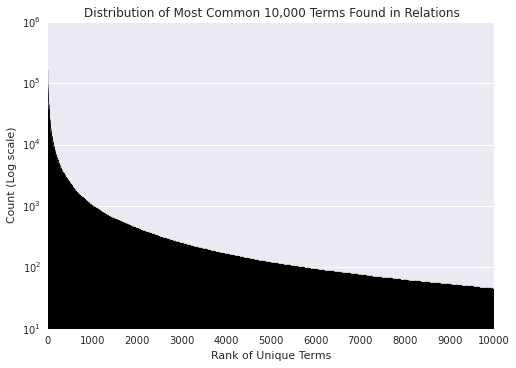

In [22]:
import seaborn as sns
ticks = range(0, 10001, 1000)
ax = sns.barplot(x="noun", y="count", data=nouns_pdf)
ax.set_yscale('log')
ax.get_xaxis().set_ticks(ticks)
ax.get_xaxis().set_ticklabels(ticks)
ax.set_title("Distribution of Most Common 10,000 Terms Found in Relations")
ax.set_ylabel("Count (Log scale)")
ax.set_xlabel("Rank of Unique Terms")

In [37]:
# let's make some candidates to try looking up.
# more than 1 occurence seems to trim off a lot
nouns\
    .filter(sql.col("count") > 1)\
    .filter(sql.length(sql.col("noun")) > 2)\
    .count()

76208

In [41]:
# write those out
nouns\
    .filter(sql.col("count") > 1)\
    .filter(sql.length(sql.col("noun")) > 2)\
    .write.format("json").save("../data/idigbio_nouns.json")